Shape of X: (5200, 96, 96, 3)
Shape of y: (5200,)


/Users/rishabhtiwari/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 77s 473ms/step


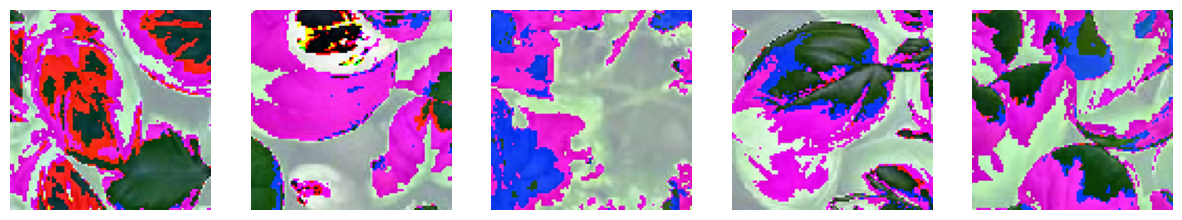

Epoch 1/50
4/4 [==============================] - 1s 105ms/step - loss: 33.1614 - accuracy: 0.7016 - val_loss: 1.0098e-06 - val_accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - 0s 93ms/step - loss: 0.8932 - accuracy: 0.9274 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 0s 91ms/step - loss: 4.3495e-32 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 0s 91ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 

/Users/rishabhtiwari/Documents/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load the dataset
data = np.load('/Users/rishabhtiwari/Documents/Uni Heidelberg/Academic Year Erasmus/Semester 1/Artificial Neural Network and Deep Learning/Practical/ANN-DL-Competition1/public_data.npz', allow_pickle=True)
X = data['data']  # Feature data
y = data['labels']  # Label data

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Load pre-trained VGG16 model without the top classification layer
vgg16_feature_extractor = VGG16(include_top=False, input_shape=(96, 96, 3), pooling='avg')

# Save the VGG16 feature extractor
vgg16_feature_extractor.save('vgg16_feature_extractor.h5')

# Preprocess the images and predict to get feature vectors
X_preprocessed = preprocess_input(X)
features = vgg16_feature_extractor.predict(X_preprocessed)

# Reduce the features to a manageable number before clustering
pca = PCA(n_components=50)  # Reduce to 50 principal components
X_pca = pca.fit_transform(features)

# Save the PCA model
joblib.dump(pca, 'pca.pkl')

# Cluster the data using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

# Identifying cluster numbers; -1 indicates outliers
plant_clusters = set(clusters) - {-1}
plant_indices = [i for i, cluster in enumerate(clusters) if cluster in plant_clusters]
X_plants = X[plant_indices]
y_plants = y[plant_indices]

# Display some images considered as outliers
outlier_indices = [i for i, cluster in enumerate(clusters) if cluster == -1]
sample_outliers = np.random.choice(outlier_indices, size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[sample_outliers[i]].astype('uint8'))
    ax.axis('off')
plt.show()

# Save the clean dataset
np.savez('clean_plant_dataset.npz', X=X_plants, y=y_plants)

# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
datagen.fit(X_plants)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_plants, y_plants, test_size=0.2, random_state=42)

# Build the classification model
classification_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the classification model
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Binary encoding for labels
label_mapping = {'healthy': 0, 'unhealthy': 1}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])

# Train the classification model
history = classification_model.fit(
    datagen.flow(X_train, y_train_numeric, batch_size=32),
    validation_data=(X_val, y_val_numeric),
    steps_per_epoch=len(X_train) // 32,
    epochs=50
)

# Save the classification model
classification_model.save('classification_model.h5')


In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from tensorflow.keras.applications.vgg16 import preprocess_input

class model:
    def __init__(self, path='/Users/rishabhtiwari/Documents/Uni Heidelberg/Academic Year Erasmus/Semester 1/Artificial Neural Network and Deep Learning/Practical/ANN-DL-Competition1/'):
        # Load the pre-trained models and PCA
        # Ensure these files are saved and submitted with your code
        self.feature_model = load_model(path + 'vgg16_feature_extractor.h5')
        self.pca = PCA(n_components=50)  # Adjust number of components if needed
        # Load PCA parameters (ensure 'pca.pkl' is saved and submitted)
        self.pca = joblib.load(path + 'pca.pkl')
        self.classification_model = load_model(path + 'classification_model.h5')

    def predict(self, X):
        # Preprocess the images
        X_preprocessed = preprocess_input(X)

        # Extract features using the VGG16 model
        features = self.feature_model.predict(X_preprocessed)

        # Reduce the features using PCA
        X_pca = self.pca.transform(features)

        # Predict using the classification model
        predictions = self.classification_model.predict(X_pca)
        
        # Convert predictions to binary labels (0 or 1)
        binary_predictions = (predictions > 0.5).astype(int).flatten()

        return binary_predictions
